[Data Preparation]
[Initial GP Training]


C:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[Surrogate Performance - KFold]
RMSE medio: 0.1476835283676969
R2 medio: -1.4491299543881766


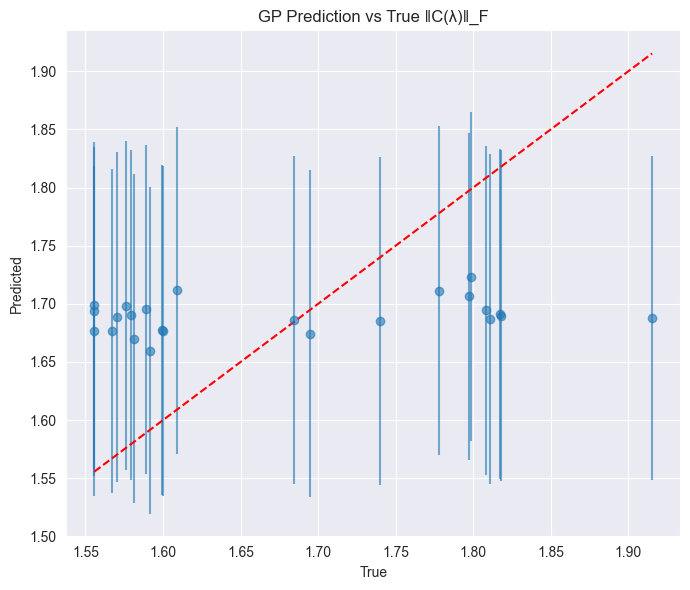

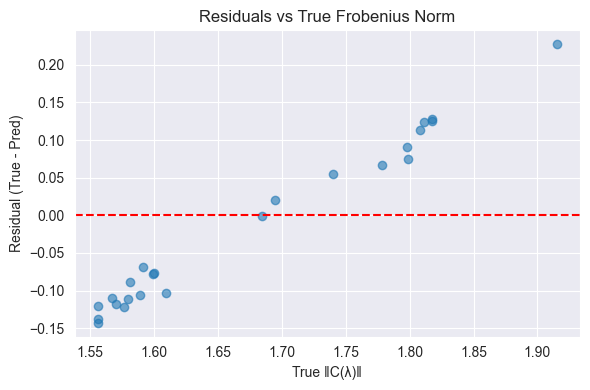


=== Iteration 1/5 ===


C:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.005. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[Surrogate Performance - KFold]
RMSE medio: 0.14867101229498278
R2 medio: -1.4697672267179587


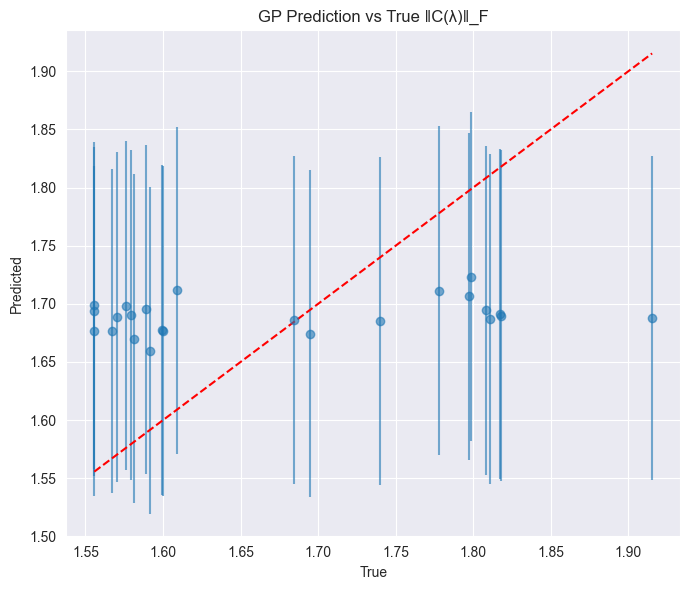

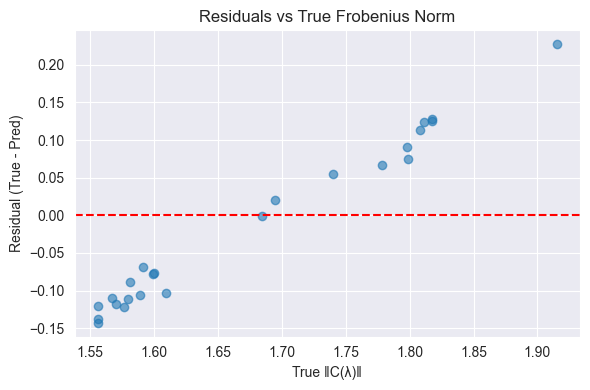


=== Iteration 2/5 ===


C:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.005. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[Surrogate Performance - KFold]
RMSE medio: 0.14768347391254108
R2 medio: -1.449129231308897


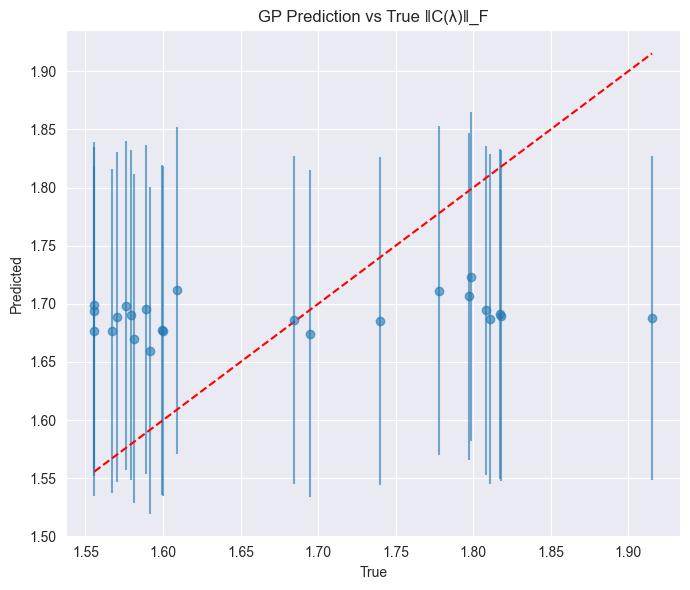

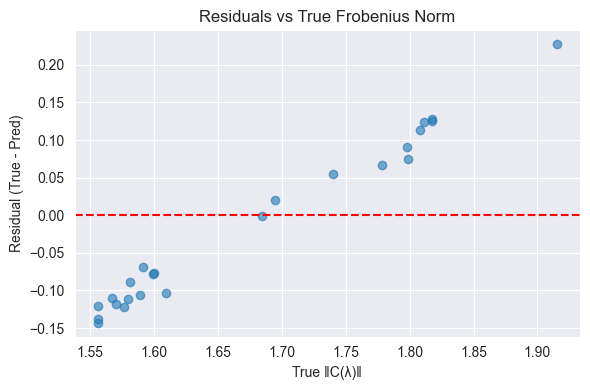


=== Iteration 3/5 ===


KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.stats import norm
from pymoo.problems.many import DTLZ2

# Problem Definition
n_obj = 3
k = 20
n_vars = n_obj + k - 1
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)

def scalarized_objective(x, lam, problem):
    f = problem.evaluate(np.array([x]))[0]
    return np.dot(lam, f)


def generate_lambda_simplex_extremes(n_samples=3000):
    base = np.identity(3)
    extra = np.random.dirichlet([0.2]*3, size=n_samples)
    return np.vstack((base, extra))

def diversity_enhanced_ei(lambda_candidates, model, X_scaler, y_best_scaled, top_k=100):
    X_cand_scaled = X_scaler.transform(lambda_candidates)
    mu, sigma = model.predict(X_cand_scaled, return_std=True)
    with np.errstate(divide='warn'):
        imp = mu.reshape(-1, 1) - y_best_scaled
        Z = imp / sigma.reshape(-1, 1)
        ei = imp * norm.cdf(Z) + sigma.reshape(-1, 1) * norm.pdf(Z)
        ei = ei.ravel()
    dist_matrix = cdist(lambda_candidates, lambda_candidates)
    diversity_score = dist_matrix.mean(axis=1)
    combined_score = ei + 0.1 * diversity_score + 0.5 * sigma
    top_idx = np.argsort(-combined_score)[:top_k]
    return lambda_candidates[top_idx]

def update_dataset_with_new_data(lambda_selected, dataset, window_size=10):
    n_vars = len([col for col in dataset.columns if col.startswith("x_star_")])
    n_obj = len([col for col in dataset.columns if col.startswith("lambda_")])

    new_x_star, new_frob_norms, new_variances, new_P_vectors = [], [], [], []
    for lam in lambda_selected:
        res = minimize(scalarized_objective, x0=np.full(n_vars, 0.5), args=(lam, problem), method='L-BFGS-B', bounds=[(0.0, 1.0)] * n_vars)
        x_opt = res.x
        new_x_star.append(x_opt)
        if len(new_x_star) >= 2:
            X_local = StandardScaler().fit_transform(np.array(new_x_star[-window_size:]))
            C = np.cov(X_local.T) + np.eye(n_vars) * 1e-8
            new_frob_norms.append(np.linalg.norm(C, ord='fro'))
            new_variances.append(np.var(X_local, axis=0))
            P = np.linalg.cholesky(C)
            new_P_vectors.append(P[np.tril_indices_from(P)])
        else:
            new_frob_norms.append(np.nan)
            new_variances.append(np.full(n_vars, np.nan))
            new_P_vectors.append(np.full((n_vars * (n_vars + 1)) // 2, np.nan))

    new_data_dict = {f"lambda_{i+1}": lambda_selected[:, i] for i in range(n_obj)}
    new_data_dict["frob_norm"] = new_frob_norms
    for i in range(n_vars):
        new_data_dict[f"x_star_{i+1}"] = [x[i] for x in new_x_star]
        new_data_dict[f"var_x_star_{i+1}"] = [v[i] for v in new_variances]
    for i in range(len(new_P_vectors[0])):
        new_data_dict[f"P_vec_{i+1}"] = [p[i] for p in new_P_vectors]
    new_data_dict["source"] = ["EI_selected"] * len(lambda_selected)

    new_df = pd.DataFrame(new_data_dict)
    updated_dataset = pd.concat([dataset, new_df], ignore_index=True)
    updated_dataset = updated_dataset.dropna(subset=["frob_norm"])
    return updated_dataset

def evaluate_gp_model_kfold(X_eval, y_eval, y_scaler):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r2_scores = []
    for train_idx, test_idx in kf.split(X_eval):
        gpr = train_gp(X_eval[train_idx], y_eval[train_idx])
        y_pred, y_std = gpr.predict(X_eval[test_idx], return_std=True)
        y_test_inv = y_scaler.inverse_transform(y_eval[test_idx].reshape(-1, 1)).ravel()
        y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        rmse_scores.append(np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
        r2_scores.append(r2_score(y_test_inv, y_pred_inv))
    print("[Surrogate Performance - KFold]")
    print("RMSE medio:", np.mean(rmse_scores))
    print("R2 medio:", np.mean(r2_scores))
    # Plot prediction vs true
    plt.figure(figsize=(7, 6))
    plt.errorbar(y_test_inv, y_pred_inv, yerr=y_std * y_scaler.scale_, fmt='o', alpha=0.6)
    plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
    plt.title("GP Prediction vs True ‖C(λ)‖_F")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Residual Plot
    y_resid = y_test_inv - y_pred_inv
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_inv, y_resid, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("True ‖C(λ)‖")
    plt.ylabel("Residual (True - Pred)")
    plt.title("Residuals vs True Frobenius Norm")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def train_gp(X, y):
    kernel = ConstantKernel(1.0, (0.001, 10.0)) * \
             Matern(length_scale=1.0, length_scale_bounds=(0.0005, 10), nu=2.5) + \
             WhiteKernel(noise_level=0.005, noise_level_bounds=(0.0001, 1))
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=1e-6, normalize_y=True)
    model.fit(X, y)
    return model
print("[Data Preparation]")
df = pd.read_csv("../dtlz2_surrogate_dataset_extended_updated.csv").dropna(subset=["frob_norm"])
X = df[["lambda_1", "lambda_2", "lambda_3"]].values
y = df["frob_norm"].values.reshape(-1, 1)
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print("[Initial GP Training]")
gpr = train_gp(X_train, y_train)
evaluate_gp_model_kfold(X_test, y_test, y_scaler)

dataset_memory = df.copy()
for iteration in range(3):
    print(f"\n=== Iteration {iteration+1}/5 ===")
    lambda_grid = generate_lambda_simplex_extremes(3000)
    y_best_scaled = np.min(y_train)
    lambda_selected = diversity_enhanced_ei(lambda_grid, gpr, X_scaler, y_best_scaled)
    dataset_memory = update_dataset_with_new_data(lambda_selected, dataset_memory)
    X_train = X_scaler.transform(dataset_memory[["lambda_1", "lambda_2", "lambda_3"]].values)
    y_train = y_scaler.transform(dataset_memory[["frob_norm"]].values).ravel()
    gpr = train_gp(X_train, y_train)
    evaluate_gp_model_kfold(X_test, y_test, y_scaler)
